# Forecasting Gold Prices using Gated Recurrent Units (GRUs)

## Contents Page

1. Section 1: Introduction
  * Section 1.1: Outline
  * Section 1.2: Loading the Data
2. Section 2: Data Preparation
  * Section 2.1: Duplicate data
  * Section 2.2: Missing values
  * Section 2.3: Outliers
  * Section 2.4: Setting the target variable
  * Section 2.5: Feature selection
  * Section 2.6: Scaling
  * Section 2.7: Splitting the data
3. Section 3: Training and evaluation
  * Section 3.1: Linear regression
  * Section 3.2: GRU

## Section 1: Introduction

Our ML pipeline is the following. Load the data, Clean the data (outliers, duplicates, missing values), split the data into train, test and validation sets, scale the data, train the models, evaluate the models performance on the test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
import my_utils as mu
import torch
from torch.utils import data
from torch import nn
from IPython import display

### Section 1.1: Outline

Section 1 is the intro which loads the data. Section 2 we begin data preparation and derive the variables. Section 3 we carry out exploratory analysis to begin analysing relationships between variables. In Section 4, we carry out our regression to get an accurate measure of the relationships between predictor and target variables.

### Section 1.2: Loading the data

The data is loaded from a CSV file. The date is used as an index in this dataset.

In [3]:
# Loading the dataframe
gold_prices = pd.read_csv('Gold_Historical.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
gold_prices.sort_values(by='Date', inplace=True)
gold_prices = gold_prices.rename(columns={'Close/Last': 'Close'})

# Printing the first 5 rows
gold_prices.head()

,Close,Volume,Open,High,Low
Date,,,,,
2012-06-11,1596.8,109042.0,1602.8,1609.3,1582.8
2012-06-12,1613.8,140522.0,1595.4,1618.8,1587.1
2012-06-13,1619.4,121539.0,1611.1,1625.8,1607.0
2012-06-14,1619.6,132247.0,1619.0,1628.9,1610.5
2012-06-15,1628.1,112994.0,1624.0,1634.5,1620.8


In [4]:
gold_prices.shape

(2551, 5)

## Section 2: Data Preparation

In this section we prepare the data for exploratory analysis. We clean the data and condense it to allow it to be interpreted more smoothly and to reduce the amount of noise that will affect possible patterns that could be identified. Tasks such as merging columns and handling missing values will be conducted.

### Section 2.1: Duplicate data

In [5]:
gold_prices[(gold_prices.duplicated() == True)]
gold_prices = gold_prices.drop_duplicates()

### Section 2.2: Missing values

We need to deal with null or missing values in the dataset. The existence of null values in the dataset causes issues during training since they function as outliers. We need to decide what's the best course of action for the null values as there are multiple ways to deal with them. We also need to understand what they mean as we could be omitting important data points.

In [6]:
print("Dataframe shape: ", gold_prices.shape)
print("Null values present: ", gold_prices.isnull().any())
gold_prices[gold_prices.isnull().any(axis=1)]

gold_prices = gold_prices.dropna()
gold_prices

Dataframe shape:  (2549, 5)
Null values present:  Close     False
Volume     True
Open      False
High      False
Low       False
dtype: bool


,Close,Volume,Open,High,Low
Date,,,,,
2012-06-11,1596.8,109042.0,1602.8,1609.3,1582.8
2012-06-12,1613.8,140522.0,1595.4,1618.8,1587.1
2012-06-13,1619.4,121539.0,1611.1,1625.8,1607.0
2012-06-14,1619.6,132247.0,1619.0,1628.9,1610.5
2012-06-15,1628.1,112994.0,1624.0,1634.5,1620.8
...,...,...,...,...,...
2022-06-03,1850.2,110502.0,1872.6,1878.6,1849.7
2022-06-06,1843.7,95742.0,1853.7,1861.2,1843.0
2022-06-07,1852.1,115125.0,1843.5,1858.2,1838.5


### Section 2.3: Outliers

In [7]:
gold_prices.describe()

,Close,Volume,Open,High,Low
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,1436.640422,180159.045798,1436.647710,1446.100000,1426.834648
std,253.697662,98145.357273,253.851912,255.477046,251.484837
min,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,1244.250000,117423.000000,1244.050000,1251.700000,1235.900000
50%,1319.200000,166626.000000,1320.300000,1328.000000,1311.800000
75%,1682.300000,230055.000000,1679.000000,1695.250000,1666.300000
max,2069.400000,787217.000000,2076.400000,2082.100000,2049.000000


Values lower than the 5th percentile : 33258.0 are considered outliers due to little trading activity


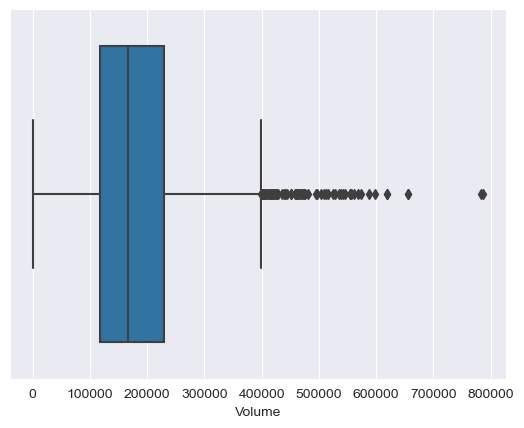

In [8]:
box = sns.boxplot(x=gold_prices.Volume)

# Bottom 5% of values in the dataset 
p = np.percentile(gold_prices.Volume, 5)
p
  
#Outlier boundaries
print('Values lower than the 5th percentile :', p, 'are considered outliers due to little trading activity')

In [9]:
gold_prices.loc[(gold_prices['Volume'] <= p)]

,Close,Volume,Open,High,Low
Date,,,,,
2012-06-21,1565.5,15315.0,1565.5,1565.5,1565.5
2012-07-31,1614.6,6673.0,1614.5,1614.5,1614.5
2012-08-07,1612.8,78.0,1614.7,1615.0,1614.4
2012-10-08,1775.7,1218.0,1777.8,1778.4,1775.8
2013-05-09,1468.6,8501.0,1468.6,1468.6,1468.6
...,...,...,...,...,...
2020-05-22,1734.6,6.0,1726.6,1726.7,1726.6
2020-05-29,1736.9,1406.0,1718.8,1738.3,1715.1
2021-03-18,1734.6,18942.0,1745.9,1756.0,1719.1


In [10]:
# Drops outliers. 
gold_prices.drop(gold_prices[gold_prices.Volume <= p].index, inplace=True)

gold_prices

,Close,Volume,Open,High,Low
Date,,,,,
2012-06-11,1596.8,109042.0,1602.8,1609.3,1582.8
2012-06-12,1613.8,140522.0,1595.4,1618.8,1587.1
2012-06-13,1619.4,121539.0,1611.1,1625.8,1607.0
2012-06-14,1619.6,132247.0,1619.0,1628.9,1610.5
2012-06-15,1628.1,112994.0,1624.0,1634.5,1620.8
...,...,...,...,...,...
2022-06-03,1850.2,110502.0,1872.6,1878.6,1849.7
2022-06-06,1843.7,95742.0,1853.7,1861.2,1843.0
2022-06-07,1852.1,115125.0,1843.5,1858.2,1838.5


In [11]:
gold_prices.describe()

,Close,Volume,Open,High,Low
count,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000
mean,1436.569224,189407.353040,1436.765493,1446.237610,1426.739161
std,256.636514,91825.966831,256.919300,258.422918,254.518685
min,1049.600000,33301.000000,1051.500000,1062.700000,1045.400000
25%,1243.400000,125318.000000,1242.800000,1250.800000,1235.100000
50%,1317.800000,170463.000000,1318.000000,1325.300000,1309.600000
75%,1694.000000,233796.000000,1695.700000,1708.300000,1683.000000
max,2069.400000,787217.000000,2076.400000,2082.100000,2049.000000


### Section 2.4: Setting the Target Variable (Close price)

* The Close Value is the final output value that will be forecasted using the Machine Learning models. This figure indicates the stock’s closing price on that particular day of stock market trading. This is assigned to the target variable.

In [12]:
#Set Target Variable
gold_prices = gold_prices.rename(columns={'Close': 'Target'})
gold_prices

,Target,Volume,Open,High,Low
Date,,,,,
2012-06-11,1596.8,109042.0,1602.8,1609.3,1582.8
2012-06-12,1613.8,140522.0,1595.4,1618.8,1587.1
2012-06-13,1619.4,121539.0,1611.1,1625.8,1607.0
2012-06-14,1619.6,132247.0,1619.0,1628.9,1610.5
2012-06-15,1628.1,112994.0,1624.0,1634.5,1620.8
...,...,...,...,...,...
2022-06-03,1850.2,110502.0,1872.6,1878.6,1849.7
2022-06-06,1843.7,95742.0,1853.7,1861.2,1843.0
2022-06-07,1852.1,115125.0,1843.5,1858.2,1838.5


In [13]:
target = gold_prices.Target

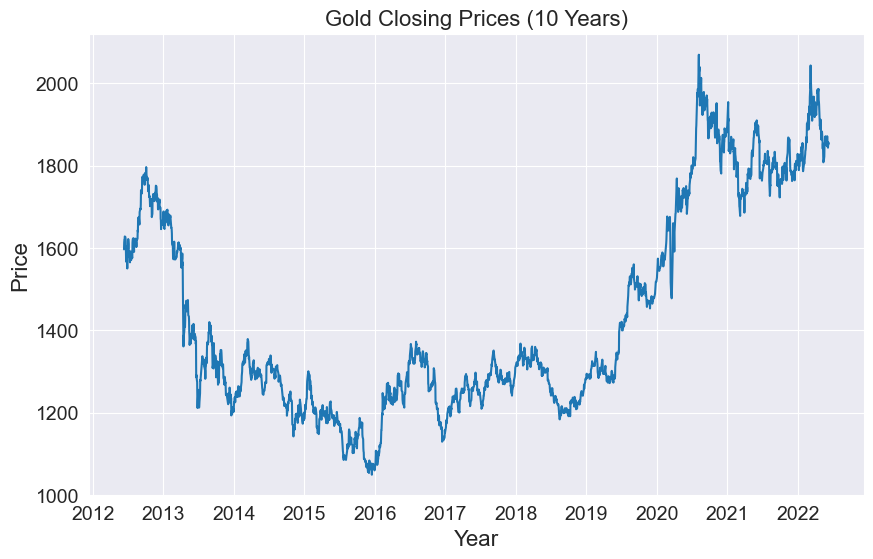

In [14]:
# Visualisation of the target variable (Close price)
fig, (a1) = plt.subplots(1, 1, figsize=(10, 6))
a1.set_title('Gold Closing Prices (10 Years)',fontsize=16)
a1.plot(gold_prices.Target)
a1.set_ylabel('Price', fontsize=16)
a1.set_xlabel('Year', fontsize=16)

a1.tick_params(axis='both', which='major', labelsize=14)
a1.tick_params(axis='both', which='minor', labelsize=14)

### Section 2.5: Feature selection

* We will be creating a new feature called daily volatility. This along with open price will be the two features used to predict the closing price. Daily volatility is calculated using (high-low)/open as a proxy. The open, high and low are highly correlated so may be telling us similar information.

In [15]:
# Daily volatility 
gold_prices['Daily Volatility'] = ((gold_prices['High'] - gold_prices['Low']) / gold_prices['Open'])
gold_prices = gold_prices.drop(columns = ['High','Low'])

In [16]:
# Previous close
gold_prices['Previous Close'] = gold_prices['Target'].shift()
gold_prices = gold_prices.dropna()

In [17]:
gold_prices = gold_prices.drop(columns = ['Target'])

### Section 2.6: Scaling

In [18]:
#Training
scaler = MinMaxScaler()
gold_prices_scaled = scaler.fit_transform(gold_prices)
gold_prices_scaled = pd.DataFrame(columns=gold_prices.columns, data=gold_prices_scaled, index=gold_prices.index)
gold_prices_scaled.head()

,Volume,Open,Daily Volatility,Previous Close
Date,,,,
2012-06-12,0.142219,0.530686,0.223054,0.536576
2012-06-13,0.117040,0.546004,0.128899,0.553246
2012-06-14,0.131243,0.553713,0.125409,0.558737
2012-06-15,0.105705,0.558591,0.091779,0.558933
2012-06-18,0.106542,0.541907,0.167833,0.567268


In [19]:
gold_prices = gold_prices_scaled

In [20]:
gold_prices['Target'] = target

In [21]:
gold_prices

,Volume,Open,Daily Volatility,Previous Close,Target
Date,,,,,
2012-06-12,0.142219,0.530686,0.223054,0.536576,1613.8
2012-06-13,0.117040,0.546004,0.128899,0.553246,1619.4
2012-06-14,0.131243,0.553713,0.125409,0.558737,1619.6
2012-06-15,0.105705,0.558591,0.091779,0.558933,1628.1
2012-06-18,0.106542,0.541907,0.167833,0.567268,1627.0
...,...,...,...,...,...
2022-06-03,0.102400,0.801151,0.172116,0.805844,1850.2
2022-06-06,0.082822,0.782711,0.107649,0.785056,1843.7
2022-06-07,0.108532,0.772758,0.117615,0.778682,1852.1


### Section 2.7: Splitting the dataset

In [22]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

* The first 4.5 years of daily data will be used as our training set the next 3 years will be used as a validation set and the last 2.5 years is the test set. The following script divides the data into training and test sets.

In [23]:
# # Checking for colinearity
# plt.plot(gold_prices['Target'])
# plt.plot(gold_prices['Open'])

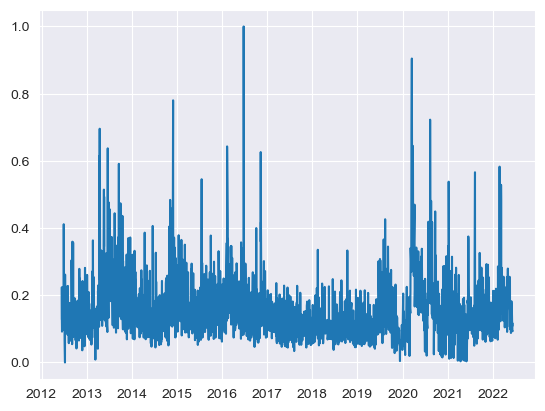

In [24]:
# Plotting intra day volatility
plt.plot(gold_prices['Daily Volatility'])

In [25]:
train = gold_prices['2012-06-09':'2016-12-31'] # Train set, trained model generates predictions for the target variable.
validation = gold_prices['2017-01-01':'2019-12-31'] # Validation set, used for hyperparameter tuning.
test = gold_prices['2020-01-01':'2022-06-09'] # Test set, used to evaluate performance of our trained model.
print('Training set:', train.shape)
print('Validation set', validation.shape)
print('Test set:', test.shape)

Training set: (1116, 5)
Validation set (690, 5)
Test set: (578, 5)


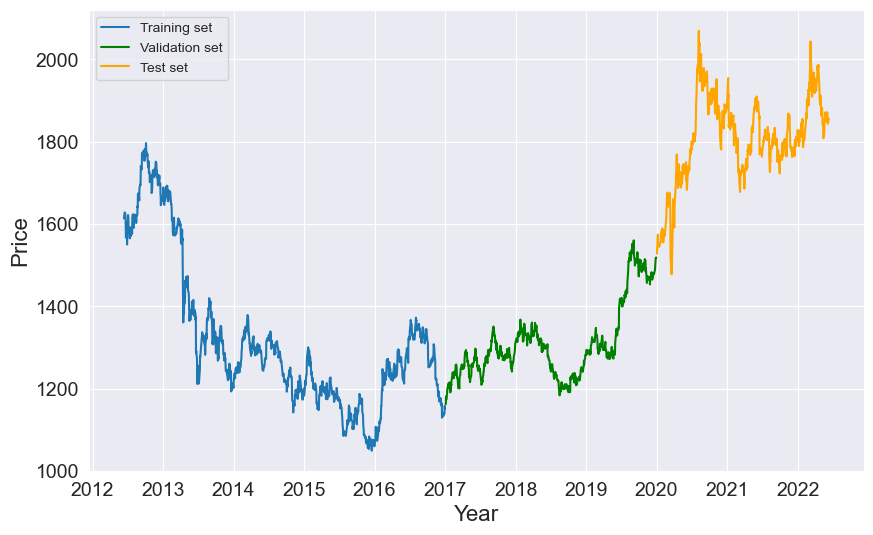

In [26]:
# Plotting true values of train, validation and test.
fig = plt.figure()
plt.plot(train.Target, label='Training set')
plt.plot(validation.Target, label='Validation set', color='green')
plt.plot(test.Target, label='Test set', color='orange')
plt.legend();

plt.xlabel('Year', fontsize=16)
plt.ylabel('Price', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.set_figheight(6)
fig.set_figwidth(10)

In [27]:
X_train = train.drop(columns = 'Target')
y_train = train.Target

X_valid = validation.drop(columns = 'Target')
y_valid = validation.Target

X_test = test.drop(columns = 'Target')
y_test = test.Target

In [28]:
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(1116, 4) (690, 4) (578, 4) (1116,) (690,) (578,)


## Section 3: Training and evaluation

### 3.1: Linear regression

In [29]:
import math, time

In [30]:
start = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
stop = time.time()

In [31]:
# calculate mean squared error
predict_train = lr.predict(X_train)
trainScore_lr = mean_squared_error(y_train, predict_train, squared=False)
print('Train Score: %.3f RMSE' % (trainScore_lr))
predict_valid = lr.predict(X_valid)
validScore_lr = mean_squared_error(y_valid, predict_valid, squared=False)
print('Validation Score: %.3f RMSE' % (validScore_lr))
predict_test = lr.predict(X_test)
testScore_lr = mean_squared_error(y_test, predict_test, squared=False)
print('Test Score: %.3f RMSE' % (testScore_lr))

Train Score: 11.709 RMSE
Validation Score: 8.985 RMSE
Test Score: 18.674 RMSE


In [32]:
# calculate mean absolute error
train_mae_lr = mean_absolute_error(y_train, predict_train)
print('Train Score: %.3f MAE' % (train_mae_lr))
valid_mae_lr = mean_absolute_error(y_valid, predict_valid)
print('Validation Score: %.3f MAE' % (valid_mae_lr))
test_mae_lr = mean_absolute_error(y_test, predict_test)
print('Test Score: %.3f MAE' % (test_mae_lr))

Train Score: 8.473 MAE
Validation Score: 7.099 MAE
Test Score: 13.620 MAE


In [33]:
# calculate r2
train_r2_lr = r2_score(y_train, predict_train)
print('Train Score: %.3f r2' % (train_r2_lr))
valid_r2_lr = r2_score(y_valid, predict_valid)
print('Validation Score: %.3f r2' % (valid_r2_lr))
test_r2_lr = r2_score(y_test, predict_test)
print('Test Score: %.3f r2' % (test_r2_lr))

Train Score: 0.996 r2
Validation Score: 0.989 r2
Test Score: 0.965 r2


In [34]:
training_time_lr = round((stop - start),2)
print(f"Training time: {training_time_lr}s")

Training time: 0.03s


### Section 3.2: GRU

We essentially choose the amount of time steps from the previous data we want to include in to the model. We can choose only the previous day / year or the last 3 days etc to influence the gradient of the current time step. time step, batch size and number of features is the tensor for the design matrix

#### Data processing 

In [35]:
#Process the data for GRU
X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_valid = np.array(X_valid).reshape(X_valid.shape[0], 1, X_valid.shape[1])
X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

In [36]:
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(1116, 1, 4) (690, 1, 4) (578, 1, 4) (1116,) (690,) (578,)


In [37]:
# Creating tensors for training
X_train = torch.tensor(X_train.astype(np.float32))
y_train_numpy = y_train
y_train = torch.tensor(y_train.astype(np.float32))
y_train = y_train.unsqueeze(1)

# Creating tensors for validation
X_valid = torch.tensor(X_valid.astype(np.float32))
y_valid_numpy = y_valid
y_valid = torch.tensor(y_valid.astype(np.float32))
y_valid = y_valid.unsqueeze(1)
                    
# Creating tensors for testing
X_test = torch.tensor(X_test.astype(np.float32))
y_test_numpy = y_test
y_test = torch.tensor(y_test.astype(np.float32))
y_test = y_test.unsqueeze(1)

In [38]:
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

torch.Size([1116, 1, 4]) torch.Size([690, 1, 4]) torch.Size([578, 1, 4]) torch.Size([1116, 1]) torch.Size([690, 1]) torch.Size([578, 1])


In [39]:
import torch.utils.data as data_utils

# Passing to DataLoader
train_dataset = data.TensorDataset(X_train, y_train) #TensorDataset object
print(train_dataset[0]) #First example in our dataset. Inputs and output.

(tensor([[0.1422, 0.5307, 0.2231, 0.5366]]), tensor([1613.8000]))


#### Defining the model

In [40]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

#### Training and prediction

In [41]:
def train_gru(batch_size, lr, num_epochs, hidden_dim, num_layers):
    train_iter = data.DataLoader(train_dataset, batch_size, shuffle=False) #DataLoader object
    # Double checking our data loader is in the right dimensions.
    train_features, train_labels = next(iter(train_iter))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    input_dim = X_train.shape[-1]
    output_dim = y_train.shape[-1]

    model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    loss = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr)

    hist = np.zeros(num_epochs)
#     start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        for X, y in train_iter:
            y_hat = model(X)

            l = loss(y_hat, y)
            hist[epoch] = l.item()

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

        l = loss(model(X_train), y_train)


        model.eval()
        predict_train = model(X_train)
        predict_train = pd.DataFrame(predict_train.detach().numpy())
        trainScore = mean_squared_error(y_train_numpy, predict_train, squared=False)
        predict_valid = model(X_valid)
        predict_valid = pd.DataFrame(predict_valid.detach().numpy())
        validScore = mean_squared_error(y_valid_numpy, predict_valid, squared=False)
        print(f'epoch {epoch + 1}, loss {l:f} Train RMSE Score: {trainScore:.2f},  Valid RMSE Score: {validScore:.2f}')
    return model, validScore, hist

In [42]:
# hidden_dim = 5
# num_layers = 2
# lr = 0.25

num_epochs = 100
best_score = float('inf')
best_params = None
best_model = None
best_hist = None
start_time = time.time()

for batch_size in [128, 256]:
    for lr in [0.5]:
        for hidden_dim in [1000]:
            for num_layers in [20]:
                params = dict(batch_size=batch_size, lr=lr, num_epochs=num_epochs, hidden_dim=hidden_dim, num_layers=num_layers)
                print("Trying", params)
                model, validScore, hist = train_gru(**params)
                if validScore < best_score:
                    print("New best model", params)
                    best_score = validScore
                    best_params = params
                    best_model = model
                    best_hist = hist

Trying {'batch_size': 128, 'lr': 0.5, 'num_epochs': 100, 'hidden_dim': 1000, 'num_layers': 20}
Feature batch shape: torch.Size([128, 1, 4])
Labels batch shape: torch.Size([128, 1])
epoch 1, loss 123147.695312 Train RMSE Score: 350.92,  Valid RMSE Score: 330.15
epoch 2, loss 34120.832031 Train RMSE Score: 184.72,  Valid RMSE Score: 102.45


KeyboardInterrupt: 

In [ ]:
training_time_gru = time.time()-start_time    
print("Training time: {}".format(training_time_gru))

In [ ]:
best_params

In [ ]:
model.eval()
predict_train = best_model(X_train)
predict_train = pd.DataFrame(predict_train.detach().numpy())

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = range(len(y_train_numpy)), y = y_train_numpy, label="Data", color='royalblue')
ax = sns.lineplot(x = predict_train.index, y = predict_train[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Gold price', size = 14, fontweight='bold')
ax.set_xlabel("Timescale (Days)", size = 14)
ax.set_ylabel("Scaled Cost (USD)", size = 14)

ax.tick_params(axis='x', labelsize=12.5)
ax.tick_params(axis='y', labelsize=12.5)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=best_hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')

ax.tick_params(axis='x', labelsize=12.5)
ax.tick_params(axis='y', labelsize=12.5)

fig.set_figheight(6)
fig.set_figwidth(16)

#### Validation set

In [ ]:
predict_valid = best_model(X_valid)
predict_valid = pd.DataFrame(predict_valid.detach().numpy())

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = range(len(y_valid_numpy)), y = y_valid_numpy, label="Data", color='royalblue')
ax = sns.lineplot(x = predict_valid.index, y = predict_valid[0], label="Validation Prediction (GRU)", color='tomato')
ax.set_title('Gold price', size = 14, fontweight='bold')
ax.set_xlabel("Timescale (Days)", size = 14)
ax.set_ylabel("Scaled Cost (USD)", size = 14)

ax.tick_params(axis='x', labelsize=12.5)
ax.tick_params(axis='y', labelsize=12.5)

fig.set_figheight(6)
fig.set_figwidth(16)

#### GRU prediction

Now that we have our model ready, we can use it to forecast the Close Value of Gold by using a model trained using the GRU network on the test set. This is accomplished by employing the model predict function on the GRU model that has been created.

In [ ]:
# Generate predictions
predict_test = best_model(X_test)
predict_test = pd.DataFrame(predict_test.detach().numpy())

In [ ]:
#Predicted vs True Close Value – GRU
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = range(len(y_test_numpy)), y = y_test_numpy, label="True Value", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (GRU)", color='tomato')
ax.set_title('GRU Prediction', size = 14, fontweight='bold')
ax.set_xlabel("Timescale (Days)", size = 14)
ax.set_ylabel("Scaled USD", size = 14)

ax.tick_params(axis='x', labelsize=12.5)
ax.tick_params(axis='y', labelsize=12.5)

fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
# calculate root mean squared error
trainScore_gru = mean_squared_error(y_train_numpy, predict_train, squared=False)
print('Train Score: %.3f RMSE' % (trainScore_gru))
validScore_gru = mean_squared_error(y_valid_numpy, predict_valid, squared=False)
print('Validation Score: %.3f RMSE' % (validScore_gru))
testScore_gru = mean_squared_error(y_test_numpy, predict_test, squared=False)
print('Test Score: %.3f RMSE' % (testScore_gru))

In [ ]:
# calculate mean absolute error
train_mae_gru = mean_absolute_error(y_train_numpy, predict_train)
print('Train Score: %.3f MAE' % (train_mae_gru))
valid_mae_gru = mean_absolute_error(y_valid_numpy, predict_valid)
print('Validation Score: %.3f MAE' % (valid_mae_gru))
test_mae_gru = mean_absolute_error(y_test_numpy, predict_test)
print('Test Score: %.3f MAE' % (test_mae_gru))

In [ ]:
# calculate r2
train_r2_gru = r2_score(y_train_numpy, predict_train)
print('Train Score: %.3f r2' % (train_r2_gru))
valid_r2_gru = r2_score(y_valid_numpy, predict_valid)
print('Validation Score: %.3f r2' % (valid_r2_gru))
test_r2_gru = r2_score(y_test_numpy, predict_test)
print('Test Score: %.3f r2' % (test_r2_gru))

In [ ]:
#Training results
lr = pd.DataFrame([trainScore_lr, train_mae_lr, train_r2_lr, training_time_lr], columns=['LR'])

gru = pd.DataFrame([trainScore_gru, train_mae_gru, train_r2_gru, training_time_gru], columns=['GRU'])

result = pd.concat([lr, gru], axis=1, join='inner')
result.index = ['Train RMSE','Train MAE','Train r2','Train time']
result = round(result,2)

In [ ]:
#Validation results
lr1 = pd.DataFrame([validScore_lr, valid_mae_lr, valid_r2_lr], columns=['LR'])

gru1 = pd.DataFrame([validScore_gru, valid_mae_gru, valid_r2_gru], columns=['GRU'])

result1 = pd.concat([lr1, gru1], axis=1, join='inner')
result1.index = ['Validation RMSE', 'Validation MAE', 'Validation r2']
result1 = round(result1,2)

In [ ]:
#Test results
lr2 = pd.DataFrame( [testScore_lr, test_mae_lr, test_r2_lr], columns=['LR'])

gru2 = pd.DataFrame([testScore_gru, test_mae_gru, test_r2_gru], columns=['GRU'])

result2 = pd.concat([lr2, gru2], axis=1, join='inner')
result2.index = ['Test RMSE', 'Test MAE', 'Test r2']
result2 = round(result2,2)

In [ ]:
result

In [ ]:
result1

In [ ]:
result2